In [106]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [107]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [146]:
import numpy as np
import pandas as pd
import io
import os
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

# Create a DataFrame from the dataset

In [147]:
# Uncomment below for Google Collab
# movies = pd.read_csv("/content/gdrive/My Drive/movies_pop_updated.csv")

# Uncomment below for local
movies_df = pd.read_csv("cleaned_movies.csv")
movies_df.head()

,Unnamed: 0,title,id,description,genres,year,director,cast,popularity,average_vote
0,0,Toy Story,862,"Led by Woody, Andy's toys live happily in his ...","animation, comedy, family",1995,John Lasseter,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",21.0,7.7
1,1,Jumanji,8844,When siblings Judy and Peter discover an encha...,"adventure, fantasy, family",1995,Joe Johnston,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",17.0,6.9
2,2,Grumpier Old Men,15602,A family wedding reignites the ancient feud be...,"romance, comedy",1995,Howard Deutch,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",11.0,6.5
3,4,Father of the Bride Part II,11862,Just when George Banks has recovered from his ...,comedy,1995,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...",8.0,5.7
4,5,Heat,949,"Obsessive master thief, Neil McCauley leads a ...","action, crime, drama, thriller",1995,Michael Mann,"Al Pacino, Robert De Niro, Val Kilmer, Jon Voi...",17.0,7.7


In [148]:
def combined_features(row):
    return row['director'] + " " + ''.join(row['cast'].split(',')[:4]) + " " + row['title']

def add_columns(movies):
  movies['index'] = range(len(movies))
  movies = movies.reset_index()

  movie_features = ["director", "cast", "title"]

  for feature in movie_features:
      movies[feature] = movies[feature].fillna('')

  movies_df["combined_features"] = movies_df.apply(combined_features, axis =1)

add_columns(movies_df)
movies_df.head()

,Unnamed: 0,title,id,description,genres,year,director,cast,popularity,average_vote,index,combined_features
0,0,Toy Story,862,"Led by Woody, Andy's toys live happily in his ...","animation, comedy, family",1995,John Lasseter,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",21.0,7.7,0,John Lasseter Tom Hanks Tim Allen Don Rickles ...
1,1,Jumanji,8844,When siblings Judy and Peter discover an encha...,"adventure, fantasy, family",1995,Joe Johnston,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",17.0,6.9,1,Joe Johnston Robin Williams Jonathan Hyde Kirs...
2,2,Grumpier Old Men,15602,A family wedding reignites the ancient feud be...,"romance, comedy",1995,Howard Deutch,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...",11.0,6.5,2,Howard Deutch Walter Matthau Jack Lemmon Ann-M...
3,4,Father of the Bride Part II,11862,Just when George Banks has recovered from his ...,comedy,1995,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...",8.0,5.7,3,Charles Shyer Steve Martin Diane Keaton Martin...
4,5,Heat,949,"Obsessive master thief, Neil McCauley leads a ...","action, crime, drama, thriller",1995,Michael Mann,"Al Pacino, Robert De Niro, Val Kilmer, Jon Voi...",17.0,7.7,4,Michael Mann Al Pacino Robert De Niro Val Kilm...


# Base Score (Director, 4 Cast, Title)
Base similarity score is derived from the director, 4 cast members, and the title.

Genre was initially included in the base score, to determine how strong the recommendations produced using only the base
score could be. It was removed after deciding to add more weighted similarity matrices for other features, due to the
fact that genre alone should be weighed very heavily.

In [149]:
def base_scores(movies):
  movie_cv = CountVectorizer(stop_words='english')
  count_matrix = movie_cv.fit_transform(movies["combined_features"])
  # print("Count Matrix:", CC_count_matrix.toarray())
  cosine_sim = cosine_similarity(count_matrix)
  # print(cosine_sim)
  return cosine_sim

base_sims = base_scores(movies_df)

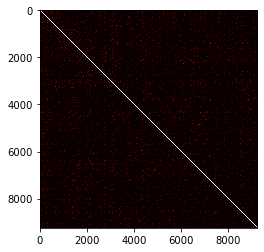

In [150]:
plt.imshow(base_sims, cmap='hot', interpolation='nearest')
plt.show()

In [151]:
def fetch_title(movies, title):
  """ Fetch a movie index using the title

  :param movies: DataFrame of movies & info
  :param title: Title of a movie
  :return: The index of the first movie matching the title
  """
  return movies[movies.title == title]["index"].values[0]

def fetch_index(movies, index):
  """ Fetch a movie title using the index

  :param movies: DataFrame of movies & info
  :param index: Index of a movie/row in the DataFrame
  :return: The title of the movie at the given index
  """
  return movies[movies.index == index]["title"].values[0]


# Compute Matrices for Genre, Description, and Year Similarity
- Genre Score Calculation (Similarity matrix based on genres)
    - Would have used Jaccard score instead, but sklearn doesn't support it on vectorizers. My custom Jaccard score matrix was too slow to compute.
    - Used CountVectorizer and cosine similarity instead
- Description Score Calculation (Similarity matrix based on genres)
    - TfidfVectorizer and cosine similarity to determine the similarity of the short descriptions.
- Year Difference Calculation Matrix (as a penalty for final weight)
- Normalize vectors from 0...1 for popularity and rating to use for final weight

Combine weighted matrices and vectors to get a final similarity matrix

In [152]:
def genre_scores(movies):
  """ Compute a similarity matrix for movies by genre

  :param movies: DataFrame of movies & info
  :return: A similarity matrix
  """
  vectorizer = CountVectorizer()
  count_matrix = vectorizer.fit_transform(movies['genres'])
  genre_sims = cosine_similarity(count_matrix)
  return genre_sims

def description_scores(movies):
  """ Compute a similarity matrix for movies by description

  :param movies: DataFrame of movies & info
  :return: A similarity matrix
  """
  vectorizer = TfidfVectorizer(stop_words='english')
  tfidf_matrix = vectorizer.fit_transform(movies["description"])
  description_sims = cosine_similarity(tfidf_matrix)
  return description_sims

def year_scores(movies):
  """ Compute a difference matrix for movies by year
  Note: Unlike the other similarity matrices, 0 is most similar

  :param movies: DataFrame of movies & info
  :return: A difference matrix
  """
  y1 = movies['year'].values
  y2 = movies['year'].values
  year_diffs = np.abs((y1[None, :] - y2[:, None]) / 100)
  return year_diffs

def norm(data, ceiling=float('inf'), floor=float('-inf')):
  """ Normalize an array of data with the provided ceiling a floor.

  :param data: An array of data
  :param ceiling: Any value >= ceiling becomes 1
  :param floor: Any value <= floor becomes 0
  :return:
  """

  if ceiling < float('inf'):
    ceiling = max(data)

  if floor > float('-inf'):
    floor = min(data)

  result = ((data - floor) / (ceiling - floor))
  for x in range(len(result)):
    if result[x] > 1:
      result[x] = 1
    if result[x] < 0:
      result[x] = 0

  return result

year_m = year_scores(movies_df)
base_m = base_scores(movies_df)
genre_m = genre_scores(movies_df)
description_m = description_scores(movies_df)
pop_v = norm(movies_df['popularity'], ceiling=50, floor=0)
rating_v = norm(movies_df['average_vote'], ceiling=10, floor=0)

print(year_m)
print(base_m)
print(genre_m)
print(description_m)
print(pop_v)
print(rating_v)

[[0.   0.   0.   ... 0.22 0.21 0.04]
 [0.   0.   0.   ... 0.22 0.21 0.04]
 [0.   0.   0.   ... 0.22 0.21 0.04]
 ...
 [0.22 0.22 0.22 ... 0.   0.01 0.26]
 [0.21 0.21 0.21 ... 0.01 0.   0.25]
 [0.04 0.04 0.04 ... 0.26 0.25 0.  ]]
[[1.         0.         0.         ... 0.0745356  0.08006408 0.08333333]
 [0.         1.         0.         ... 0.07784989 0.         0.08703883]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.0745356  0.07784989 0.         ... 1.         0.         0.        ]
 [0.08006408 0.         0.         ... 0.         1.         0.        ]
 [0.08333333 0.08703883 0.         ... 0.         0.         1.        ]]
[[1.         0.33333333 0.40824829 ... 0.40824829 0.33333333 0.        ]
 [0.33333333 1.         0.         ... 0.         0.         0.        ]
 [0.40824829 0.         1.         ... 1.         0.40824829 0.40824829]
 ...
 [0.40824829 0.         1.         ... 1.         0.40824829 0.40824829]
 [0.33333333 0.         0.40824

In [153]:
def combine(base_scores, genre_scores, description_scores, year_scores, popularity_vector, rating_vector):
  """ Combines similarity matrices and vectors using addition and weights

  :param base_scores: Base similarity matrix
  :param genre_scores: Genre similarity matrix
  :param description_scores: Description similarity matrix
  :param year_scores: Year difference matrix
  :param popularity_vector: Popularity vector
  :param rating_vector: Rating vector
  :return: Resulting similarity matrix from the weighted computation
  """
  weighted_base = np.multiply(base_scores, 2)
  weighted_genres = np.multiply(genre_scores, 2.1)
  weighted_descriptions = np.multiply(description_scores, 1.2)
  weighted_years = np.multiply(year_scores, -5)

  weighted_pop = np.multiply(popularity_vector, 1)
  weighted_ratings = np.multiply(rating_vector, 2)

  combined_matrix = weighted_base + weighted_genres + weighted_descriptions + weighted_years
  combined_matrix = combined_matrix + (weighted_pop + weighted_ratings)[:, np.newaxis]

  return combined_matrix

scores = combine(base_m, genre_m, description_m, year_m, pop_v, rating_v)

/var/folders/sf/mblmxltx6bxc945qnhg523vm0000gn/T/ipykernel_40005/3543326102.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  combined_matrix = combined_matrix + (weighted_pop + weighted_ratings)[:, np.newaxis]


# Make the Recommendations
Provide a ranked list of the 'most similar' movies to the input movies provided.

In [162]:
def recommend(movies, scores, titles, count):
  """ Make a recommendation list based on a list of titles

  :param movies: DataFrame of movies & info
  :param scores: Similarity matrix for the movies
  :param titles: List of input titles
  :param count: Number of recommendations to output
  :return:
  """
  proximity_arr = np.zeros([len(movies), 2])
  proximity_arr[:,0] = np.array(movies["index"], dtype=int)
  for title in titles:
    movie_index = fetch_title(movies, title)
    proximity_row = np.array(scores[movie_index])
    proximity_arr[:,1] = proximity_arr[:,1] + proximity_row

  movie_proximity_sorted = proximity_arr[proximity_arr[:, 1].argsort()][::-1]

  i = 0
  n = 1
  print("Recommendations:")
  while n <= count:
    title = fetch_index(movies, int(movie_proximity_sorted[i, 0]))
    if title not in titles:
      print(f"{n}. {title}")
      n+=1
    i+=1


num_recommendations = 10
titles = ["Paul Blart: Mall Cop", "Step Brothers"]
recommend(movies_df, scores, titles, num_recommendations)

Recommendations:
1. Paul Blart: Mall Cop 2
2. Talladega Nights: The Ballad of Ricky Bobby
3. The Promotion
4. Anchorman 2: The Legend Continues
5. I Love You, Man
6. Brüno
7. Did You Hear About the Morgans?
8. Strange Wilderness
9. Anchorman: The Legend of Ron Burgundy
10. American Pie Presents: The Book of Love


# Preliminary Exploratory Data Analysis
This section was primarily used before cleaning the dataset used here. Analysis involving cleaned columns and rows
was removed from this notebook.

total of 20 unique genres from 23579 occurances.


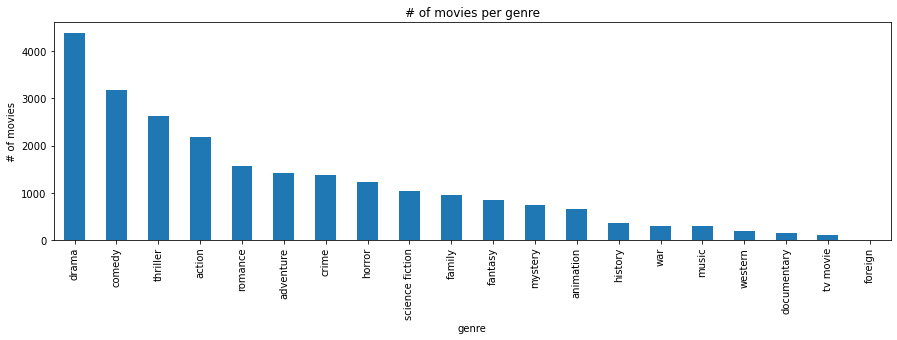

In [155]:
all_genres = [s.split(", ") for s in movies_df[movies_df.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")
pd.Series(genres).value_counts().plot(kind='bar', figsize=(15, 4))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

Total of 100 uinque years from 1896 to 2017


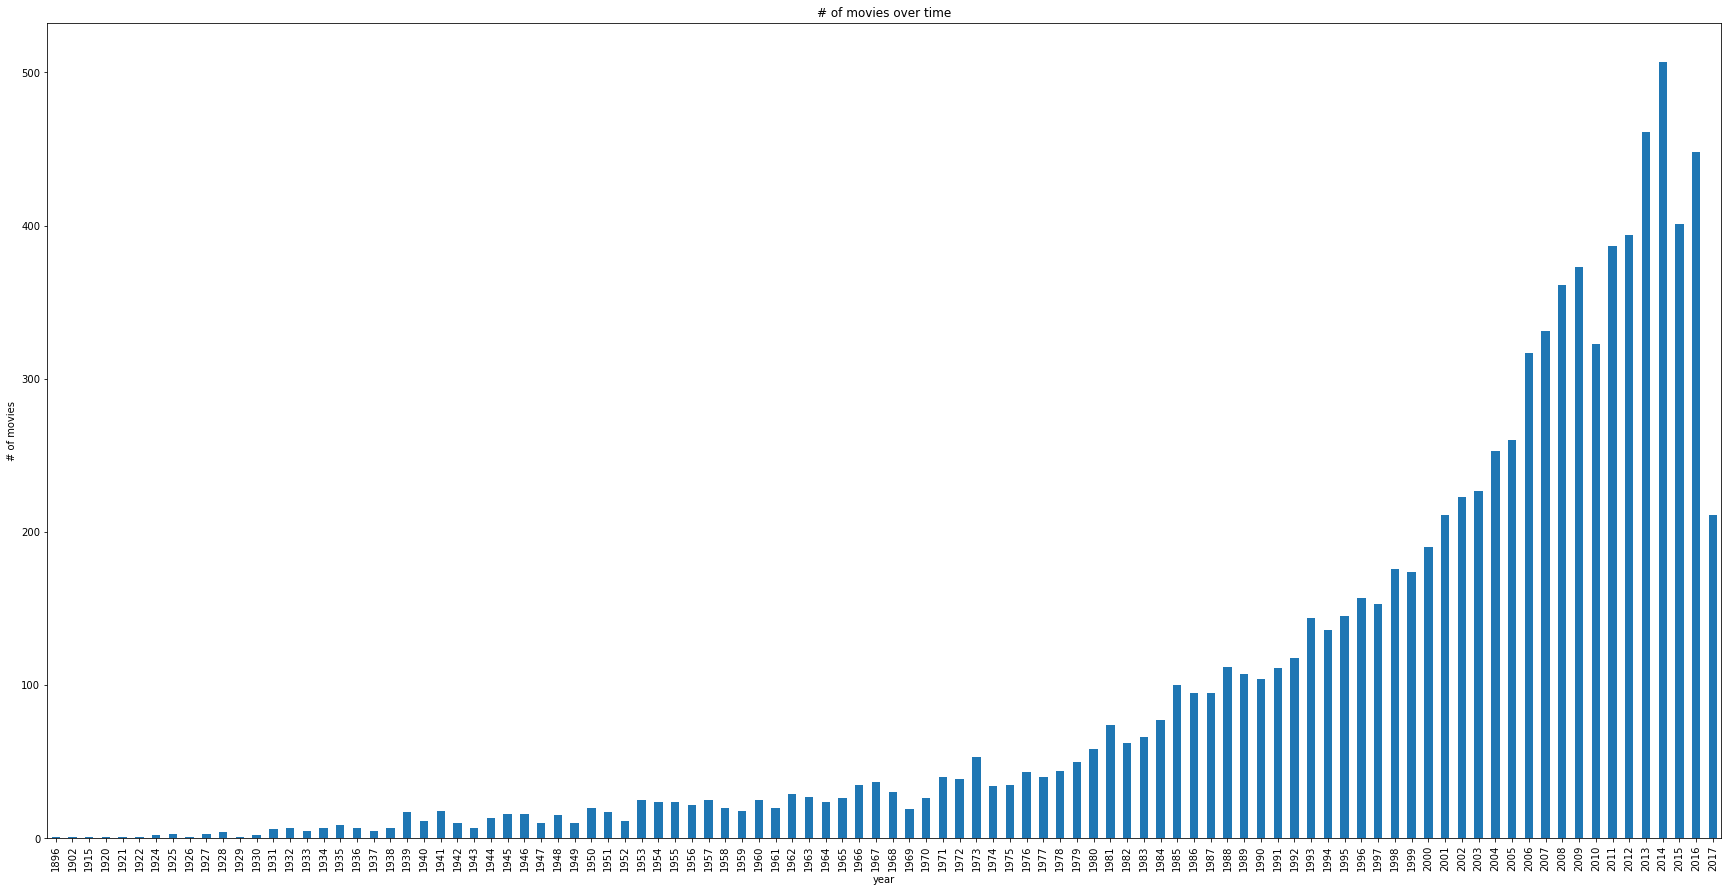

In [156]:
movies_df['year'] = movies_df['year'].replace(0, np.NaN)
years = movies_df[movies_df.year.notnull()].year # get rows where year is not None
print (f"Total of {len(set(years))} uinque years from {min(years)} to {max(years)}")
pd.Series(years).value_counts().sort_index().plot(kind='bar', figsize=(30, 15))
plt.title("# of movies over time")
plt.ylabel("# of movies")
plt.xlabel("year")
plt.show()

count    9242.000000
mean        6.259013
std         0.916086
min         1.900000
25%         5.700000
50%         6.300000
75%         6.900000
max        10.000000
Name: average_vote, dtype: float64


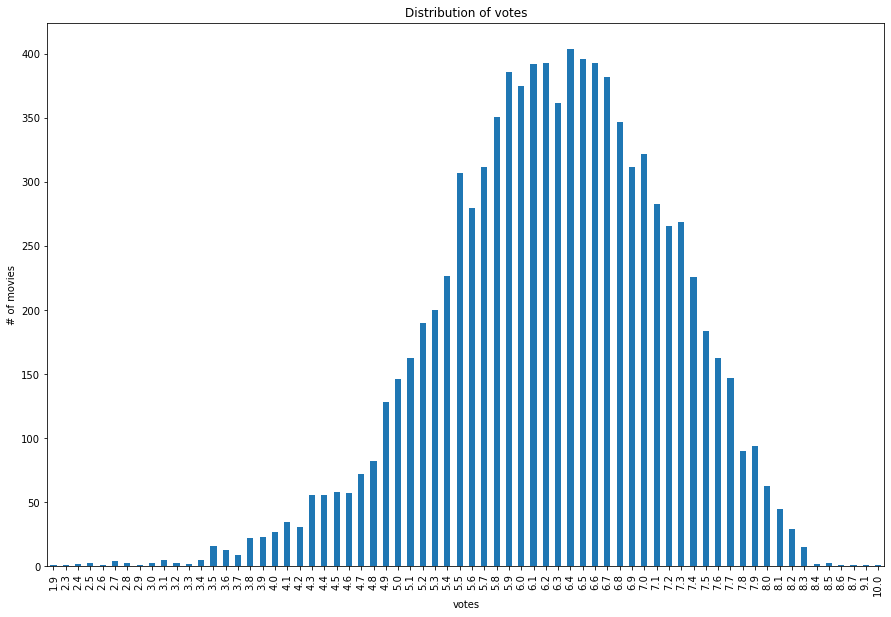

In [157]:
movies_df['average_vote'] = movies_df['average_vote'].replace(0, np.NaN)
print (movies_df['average_vote'].describe())
pd.Series(movies_df['average_vote']).value_counts().sort_index().plot(kind='bar', figsize=(15, 10))
plt.title("Distribution of votes")
plt.ylabel("# of movies")
plt.xlabel("votes")
plt.show()
